# Bayesian Wind Power Investment Model

### Import packages

In [1]:
import pystan
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sb
import numpy as np
from numpy import random as rd
from scipy.stats import exponweib
from scipy.stats import weibull_min
import random




In [ ]:
Import packages for converting 

In [ ]:
import os
os.chdir("/Users/johannesmauritzen/research/wind_invest_model/")
from wind_turbine import wind_turbine
from wind_prior_generation import wind_prior_generation

### First: a few classes 

### Wind Turbine Class

A class that takes as input

In [15]:
from textwrap import dedent
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sb
import math
import os
from scipy.interpolate import interp1d

os.chdir("/Users/johannesmauritzen/research/wind_invest_model/")

class wind_turbine(object):

	def __init__(self, curve_speeds, power_points, min_speed=4, rated_wind=15, rated_power=3000, cut_out=25):
		self.curve_speeds=curve_speeds
		self.power_points=power_points
		self.min_speed = min_speed
		self.rated_wind = rated_wind
		self.rated_power = rated_power
		self.cut_out = cut_out

		#initialize power function
		self.power_function = power_function
		self.power_f=interp1d(self.curve_speeds, self.power_points, kind="cubic")
	def __repr__(self):
		return self.__str__()

	def __str__(self):
		m = """\
        Wind turbine instance:
          - Min Speed (m/s)					: {ms}
          - Rated Power (kW)				: {p}
          - Rated Power at Wind Speed (m/s) : {ws} 
          - Cut out: {co}
        """
		return(dedent(m.format(ms=self.min_speed, p=self.rated_power, ws=self.rated_wind, co=self.cut_out)))

	def __call__(self, wind_speeds):
		#Call directly randomly generates wind speed 
		#from weibull distribution
		return(self.power_function(wind_speeds))
		

	def power_function(self, wind_speeds):
		"""
		takes in an array of wind_speeds, and exports power output according 
		to power curve
		"""
		print(wind_speeds)
		power_kw =[]
		for w in wind_speeds:
			if w<self.min_speed:
				power_kw.append(0)
			elif w>=self.cut_out:
				power_kw.append(0)
			elif w>=self.rated_wind and w<self.cut_out:
				power_kw.append(self.rated_power)
			else:
				power_kw.append(float(self.power_f(w)))
		return(power_kw)

### Prior creation class

In [16]:
#prior_generation.py
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import fmin
from scipy.stats import weibull_min
from scipy.stats import exponweib
import math
import matplotlib.pyplot as plt
import numpy as np
from textwrap import dedent


import os
os.chdir("/Users/johannesmauritzen/research/wind_invest_model/")

from wind_turbine import wind_turbine


class wind_prior_generation(object):
	"""
	inputs a pd.DataFrame of average wind data
	returns sample from wind prior
	"""
	def __init__(self, wind_data):
		self.wind_data = wind_data
		self.wind_data_long =pd.melt(wind_data)

		#initialize fitting model
		self.lmbd_hat, self.k_hat=fmin(self.weibul_sq_error, [2,2])

	def __call__(self):
		m= """\
		Weibull with parameters:
		shape: 		{shape}
		scale:		{scale}
		"""
		return(dedent(m.format(shape=self.k_hat, scale=self.lmbd_hat*np.sqrt(3/2)))
)

	def weibul_sq_error(self, p):
		"""
		Takes in vector of monthly mean wind speeds, mu, 
		and fits the best weibull distribution by least squares
		by way of weibull mean function:
		mu=lambda*gamma(1+1/k)
		"""
		mu=self.wind_data_long.value
		sq_errors=(mu - p[0] * math.gamma(1+1/p[1]))**2
		return(sum(sq_errors))

	def weib(self, x,k,lmbd):
	     return (k / lmbd) * (x / lmbd)**(k - 1) * np.exp(-(x / lmbd)**k)

	def create_wind_prior(self, min_speed=0, max_speed=50, num_bins=200):
		x_wind=np.linspace(min_speed,max_speed,num_bins)
		prior_dist=[self.weib(x, self.k_hat, self.lmbd_hat*np.sqrt(3/2)) for x in x_wind]
		return(np.array([x_wind, prior_dist]))

	def sample_from_prior(self, years=1):
		#now sample from distribution,
		# turn into wind data and see how much it costs
		prior_winds=weibull_min.rvs(c=self.k_hat, scale=(self.lmbd_hat*np.sqrt(3/2)), size=8760)
		return(prior_winds)










### Create priors


Given the location of our proposed wind turbine/wind farm (Andmyran), I find the location of the three closest weather stations: Andenes, Harstad and Sortland. Here data is available at monthly averages for the last twelve months. We put all these in a data frame. 

In [4]:
andenes_maws = [6.6, 7.9, 8.6, 7.8, 7.1, 5.7, 5.8, 5.8, 5.0, 3.9,5.9, 5.6]
harstad_maws = [2.1, 2.5, 2.3, 2.4, 2.0, 1.7, 1.9, 1.7, 1.9, 1.3, 2.4, 2.3]
sortland_maws = [3.3, 4.8, 4.7, 3.5, 3.3, 3.3, 3.2, 3.4, 3.8, 3.9, 5.1, 4.0]
avg_wind_speed_data = pd.DataFrame({'andenes':andenes_maws, 
	'harstad':harstad_maws, 'sortland':sortland_maws})


Create an instance of a prior object from this data. This object creates a prior distribution of wind speeds based on a least squares fit and characteristics of the weibull distribution

In [5]:
andmyran_prior = wind_prior_generation(avg_wind_speed_data)

Optimization terminated successfully.
         Current function value: 136.116389
         Iterations: 55
         Function evaluations: 106


Form the prior instance, a pdf function over wind speeds is produced as well as a random sample drawn from that distribution

In [11]:
wind, prior = andmyran_prior.create_wind_prior()
wind_sample = andmyran_prior.sample_from_prior()

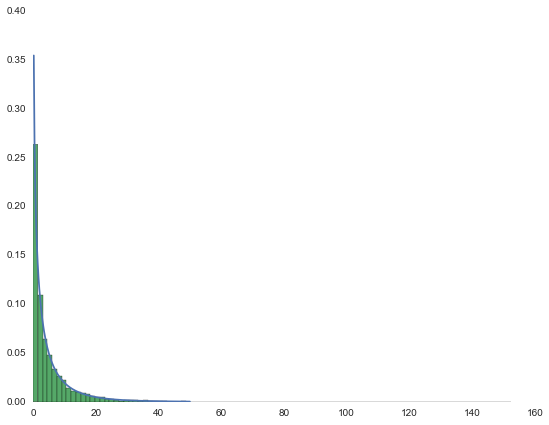

In [9]:
%matplotlib inline
fig, ax = plt.subplots()
fig.set_size_inches(9,7)
ax.plot(wind, prior)
ax.hist(wind_sample, normed=1, bins=100)
plt.show()

### Convert sample of wind speeds from prior distribution into power via power function

We create an instance of a wind turbine from the wind turbine class with data showing the relationship between wind speed and power output. Minimum speed is 4m/s, maximum/rated output is reached at 15 m/s and cut-out is at 25 m/s

In [13]:
wind_speed=np.array([4,5,6,7,8,9,10, 11, 12, 13, 14, 15])
power_kw_v90=np.array([85, 200, 350, 590, 900, 1300, 1720, 2150, 2560, 2840, 2980, 3000])

v90_turbine = wind_turbine(curve_speeds=wind_speed, power_points = power_kw_v90)
power_output = np.sum(v90_turbine(wind_sample))


[  2.53113259   0.6980208    0.1767123  ...,   0.02217957  14.56335446
   1.08202164]


Generate 500 samples of yearly wind output from the prior wind distribution

In [14]:
yearly_power_output = []
for i in range(500):
	wind_sample=andmyran_prior.sample_from_prior()
	power = v90_turbine(wind_sample)
	yearly_power_output.append(np.sum(power))


[  0.50781238   2.75462516   0.12161682 ...,  28.45744885   0.33966423
   3.04418345]
[ 0.11015422  9.69052187  0.09083975 ...,  0.15494223  0.16025656
  1.40607048]
[ 0.0249757   2.8504008   0.80137549 ...,  4.13599327  4.91163354
  0.57049905]
[  1.70347624   0.44870617  15.38950896 ...,   0.73181945  12.54278217
  17.9942533 ]
[  3.5690465    0.07134297   0.8472273  ...,   0.28906284  21.50440126
   0.15340469]
[  5.09793440e+01   4.77120176e+00   1.44820678e+01 ...,   3.13002767e-03
   9.91006943e-01   2.08750791e-01]
[ 44.67179063   5.59055108   2.89091122 ...,   6.72719572   5.61390415
   2.43509892]
[  0.32760974   3.37975608  21.60793675 ...,   3.4428505    4.36869201
   3.69269395]
[ 26.77898965   2.0385332    5.01529247 ...,   0.0349981   11.50052347
   9.26419374]
[ 4.23752347  0.91362251  2.93828321 ...,  9.47471768  0.20717264
  1.06348807]
[  0.63390821  13.91008319   7.5825261  ...,   0.74802451  22.77894224
   0.96128965]
[  7.29684499   0.73987211   0.12831759 ...,  18